# Train Keras model and make performance plots

In [1]:
#Data Processing
import numpy as np
from numpy import loadtxt, expand_dims
import h5py
import sys

#ML model
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense,Flatten, Dropout, Activation, concatenate, BatchNormalization, GRU, Add, Conv1D, Conv2D, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model


from sklearn.metrics import roc_curve
from sklearn.metrics import auc

#Plot settings
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.ROOT)

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

#line thickness
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 5

#Just to efficiently save plots
plot_dir = "../plot/"
print("Saving plot to: ", plot_dir)
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
save_path = plot_dir + dt_string

Saving plot to:  ../plot/


## 1. Train model

In [2]:
#Load in the datasets for training and compiling the sample weights
with h5py.File('../data/trainingDataTTdXYPup.h5', 'r') as hf:
    dataset = hf["Training Data"][:]
with h5py.File('../data/sampleDataTTdXYPup.h5', 'r') as hf:
    sampleData = hf["Sample Data"][:]
    

#Separate datasets into inputs and outputs, expand the dimensions of the inputs to be used with Conv1D layers
X = dataset[:,0:len(dataset[0])-1]
X = expand_dims(X, axis=2)
y = dataset[:,len(dataset[0])-1]

print("X shape: ", X.shape)
print("y shape: ", y.shape)

#Establish the sample weights
thebins = np.linspace(0, 200, 100)
bkgPts = []
sigPts = []
for i in range(len(sampleData)):
    if y[i]==1:
        sigPts.append(sampleData[i][0])
    if y[i]==0:
        bkgPts.append(sampleData[i][0])
bkg_counts, binsbkg = np.histogram(bkgPts, bins=thebins)
sig_counts, binssig = np.histogram(sigPts, bins=thebins)
a = []
for i in range(len(bkg_counts)):
    tempSig = float(sig_counts[i])
    tempBkg = float(bkg_counts[i])
    if tempBkg!=0:
        a.append(tempSig/tempBkg)
    if tempBkg==0:
        a.append(0)
        
#Normalize the sample weights above a certain pT
for i in range(42,len(a)):
    a[i]=0.7
    
#Add in the sample weights, 1-to-1 correspondence with training data
#Sample weight of all signal events being equal to 1
#Sample weight of all background events being equal to the sig/bkg ratio at that jet's pT
weights = []
for i in range(len(sampleData)):
    if y[i]==1:
        weights.append(1)
    if y[i]==0:
        jetPt = sampleData[i][0]
        tempPt = int(jetPt/2)
        if tempPt>98:
            tempPt = 98
        weights.append(a[tempPt])

X shape:  (389705, 130, 1)
y shape:  (389705,)


In [10]:
#Zero padding X
X= np.pad(X, ((0,0),(0,20),(0,0)), 'constant')

In [24]:
#Define the model
model = Sequential()
model.add(Conv1D(filters=20, kernel_size=15, strides=15, activation='relu',input_shape=X.shape[1:]))
model.add(Conv1D(filters=5, kernel_size=1,activation='relu'))
model.add(Flatten())
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 10, 20)            320       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 10, 5)             105       
_________________________________________________________________
flatten_6 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_19 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 11        
Total params: 1,666
Trainable params: 1,666
Non-trainable params: 0
____________________________________________________

In [25]:
#Train the network
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5)

model.fit(X,y,
          epochs=50,
          batch_size=50,
          verbose=2,
          sample_weight=np.asarray(weights),
          validation_split=0.20,
          callbacks=[callback])

2022-06-28 11:26:05.874817: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
6236/6236 - 13s - loss: 0.5237 - binary_accuracy: 0.6111 - val_loss: 0.5161 - val_binary_accuracy: 0.6405
Epoch 2/50
6236/6236 - 7s - loss: 0.5085 - binary_accuracy: 0.6339 - val_loss: 0.5133 - val_binary_accuracy: 0.6031
Epoch 3/50
6236/6236 - 7s - loss: 0.5029 - binary_accuracy: 0.6418 - val_loss: 0.5025 - val_binary_accuracy: 0.6437
Epoch 4/50
6236/6236 - 7s - loss: 0.4994 - binary_accuracy: 0.6469 - val_loss: 0.5001 - val_binary_accuracy: 0.6443
Epoch 5/50
6236/6236 - 7s - loss: 0.4971 - binary_accuracy: 0.6509 - val_loss: 0.5021 - val_binary_accuracy: 0.6600
Epoch 6/50
6236/6236 - 7s - loss: 0.4946 - binary_accuracy: 0.6539 - val_loss: 0.4970 - val_binary_accuracy: 0.6491
Epoch 7/50
6236/6236 - 7s - loss: 0.4925 - binary_accuracy: 0.6552 - val_loss: 0.4937 - val_binary_accuracy: 0.6550
Epoch 8/50
6236/6236 - 7s - loss: 0.4908 - binary_accuracy: 0.6586 - val_loss: 0.4933 - val_binary_accuracy: 0.6570
Epoch 9/50
6236/6236 - 6s - loss: 0.4892 - binary_accuracy: 0.6611 - va

In [26]:
model.save('../saved_model/L1BTagModel_15_feat_TTdXYPup.h5')

## 2. Make performance plot for the model

In [29]:
#Establish the input and output data for each dataset, expanding dimensions for compatability with Conv1D layer input
def load_testing_data(data_path):
    
    with h5py.File(data_path, 'r') as hf:
        dataset = hf["Testing Data"][:]
    X_test = dataset[:,0:len(dataset[0])-1]
    X_test = expand_dims(X_test, axis=2)
    y_test = dataset[:,len(dataset[0])-1]
    
    #zero padding X_test
    X_test= np.pad(X_test, ((0,0),(0,20),(0,0)), 'constant')
    
    return X_test, y_test

X_test, y_test = load_testing_data('../data/testingDataTTdXYPup.h5')

In [30]:
#Load in respective model for the datasets
#model_1 = load_model('../saved_model/L1BTagModel_100GRU.h5')
model_2 = load_model('../saved_model/L1BTagModel_15_feat_TTdXYPup.h5')

#Creating ROC curves based on model predictions for each dataset
#y_pred_1 = model_1.predict(X_test).ravel()
y_pred_2 = model_2.predict(X_test).ravel()

#fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_1)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_2)

#auc_1 = auc(fpr_1, tpr_1)
auc_2 = auc(fpr_2, tpr_2)

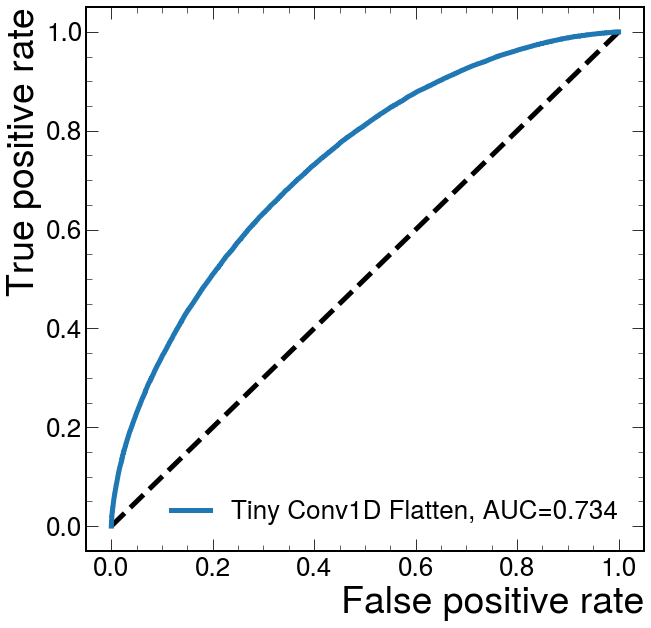

In [31]:
#Create plot for ROC
plt.figure(1)
plt.plot([0,1],[0,1],'k--')

#plt.plot(fpr_1, tpr_1, label='Conv1D 100GRU, AUC={:.3f}'.format(auc_1))
plt.plot(fpr_2, tpr_2, label='Tiny Conv1D Flatten, AUC={:.3f}'.format(auc_2))

#Establish labels and save image
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')

#p_path = save_path + "v2LargerTinyConv1D_100GRU_Flatten.pdf"
#print(p_path)
#plt.savefig(p_path, bbox_inches='tight')